transaction_id,user_id,amount,country,channel,merchant_category,transaction_time,is_fraud,fraud_probability,fraud_prediction,date
228,5,34.91,PL,web,gaming,2024-06-12T08:18:55.000Z,0,0.0027767057831352042,0.0,2024-06-12
1073,22,64.8,IT,web,electronics,2024-06-12T06:39:16.000Z,0,0.0029279270909726737,0.0,2024-06-12
1706,34,64.72,ES,web,fashion,2024-06-12T07:45:10.000Z,0,0.003010121953600407,0.0,2024-06-12
1810,36,22.63,US,app,electronics,2024-06-12T07:14:01.000Z,0,0.0015123328650163148,0.0,2024-06-12
2039,40,102.35,US,web,electronics,2024-06-12T21:58:31.000Z,0,0.008971397495394249,0.0,2024-06-12
2501,49,342.23,TR,web,gaming,2024-06-12T03:45:55.000Z,0,0.0034091471550193138,0.0,2024-06-12
3429,68,202.11,PL,app,gaming,2024-06-12T04:06:44.000Z,0,0.0013629463981749401,0.0,2024-06-12
3520,70,108.58,TR,app,travel,2024-06-12T22:21:03.000Z,0,0.0015542302899316052,0.0,2024-06-12
3768,75,6.18,DE,web,gaming,2024-06-12T07:19:24.000Z,0,0.004790977405179295,0.0,2024-06-12
4476,90,237.72,FR,web,gaming,2024-06-12T21:13:34.000Z,0,0.0027965125710987418,0.0,2024-06-12


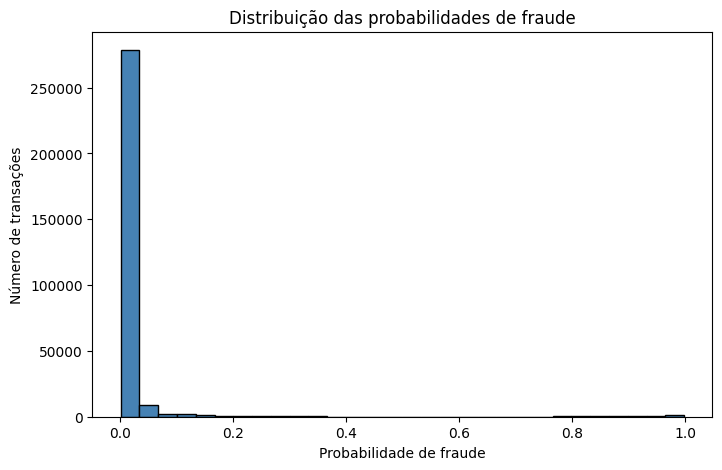

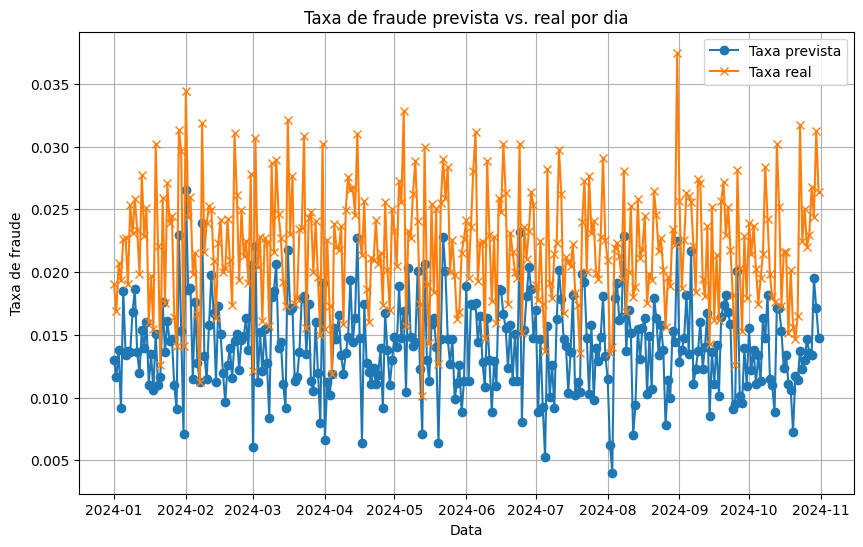

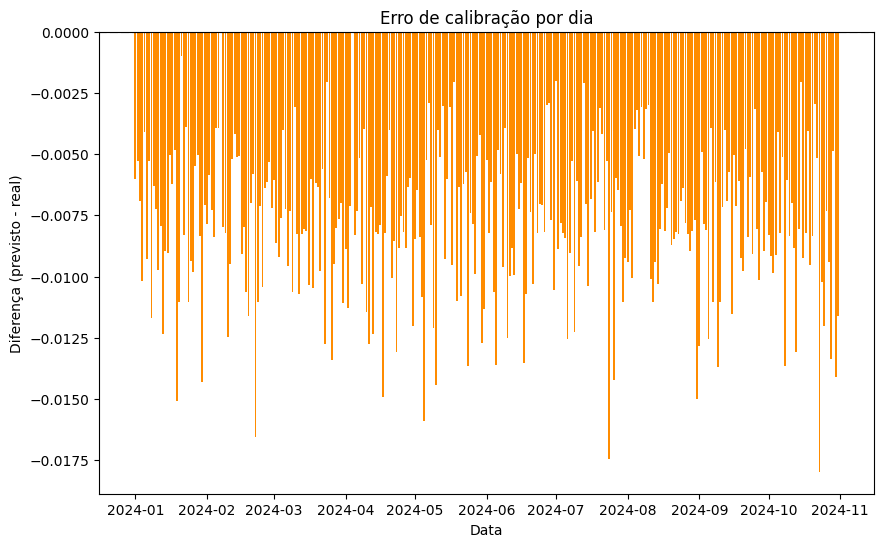

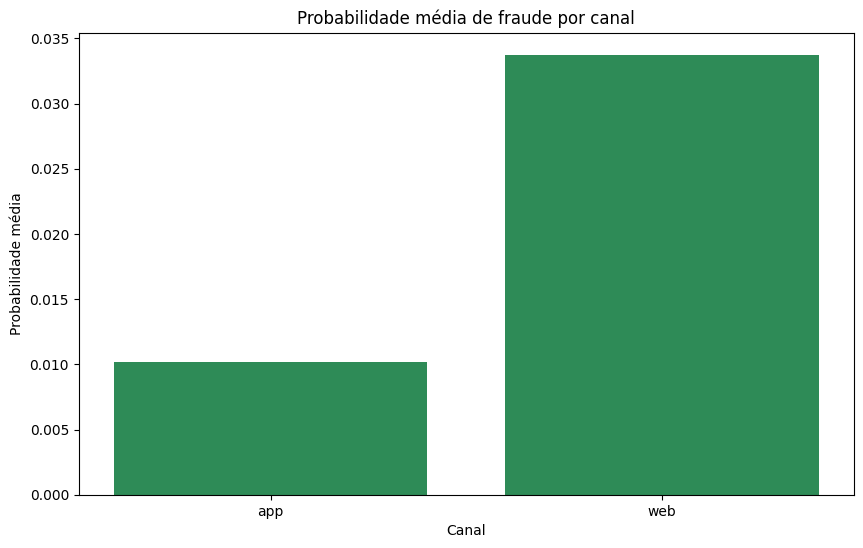

message,severity
Drift detectado: média da probabilidade (0.02) fora do intervalo esperado.,CRITICAL


In [0]:
# Databricks notebook source
# Databricks notebook source
# MAGIC %md
# MAGIC # Monitoramento de modelo de fraude - Dashboard + Alertas

# COMMAND ----------

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Tabela de predições
PREDICTIONS_TABLE = "workspace.default.predictions_delta"
ALERTS_TABLE = "workspace.default.monitoring_alerts"

# COMMAND ----------

# Carregar previsões
pred_df = spark.table(PREDICTIONS_TABLE)

display(pred_df.limit(10))

# COMMAND ----------
# MAGIC %md
# MAGIC ## Distribuição das probabilidades de fraude

probabilities = pred_df.select("fraud_probability").toPandas()

plt.figure(figsize=(8,5))
plt.hist(probabilities["fraud_probability"], bins=30, color="steelblue", edgecolor="black")
plt.title("Distribuição das probabilidades de fraude")
plt.xlabel("Probabilidade de fraude")
plt.ylabel("Número de transações")
plt.show()

# COMMAND ----------
# MAGIC %md
# MAGIC ## Taxa de fraude prevista vs. real por dia

fraud_rates = (
    pred_df
    .groupBy("date")
    .agg(
        F.avg("fraud_prediction").alias("predicted_fraud_rate"),
        F.avg("is_fraud").alias("actual_fraud_rate")
    )
    .orderBy("date")
    .toPandas()
)

plt.figure(figsize=(10,6))
plt.plot(fraud_rates["date"], fraud_rates["predicted_fraud_rate"], label="Taxa prevista", marker="o")
plt.plot(fraud_rates["date"], fraud_rates["actual_fraud_rate"], label="Taxa real", marker="x")
plt.title("Taxa de fraude prevista vs. real por dia")
plt.xlabel("Data")
plt.ylabel("Taxa de fraude")
plt.legend()
plt.grid(True)
plt.show()

# COMMAND ----------
# MAGIC %md
# MAGIC ## Erro de calibração

fraud_rates["calibration_error"] = fraud_rates["predicted_fraud_rate"] - fraud_rates["actual_fraud_rate"]

plt.figure(figsize=(10,6))
plt.bar(fraud_rates["date"], fraud_rates["calibration_error"], color="darkorange")
plt.title("Erro de calibração por dia")
plt.xlabel("Data")
plt.ylabel("Diferença (previsto - real)")
plt.axhline(0, color="black", linestyle="--")
plt.show()

# COMMAND ----------
# MAGIC %md
# MAGIC ## Estatísticas por canal

channel_stats = (
    pred_df
    .groupBy("channel")
    .agg(
        F.avg("fraud_probability").alias("avg_fraud_probability"),
        F.avg("fraud_prediction").alias("predicted_fraud_rate"),
        F.avg("is_fraud").alias("actual_fraud_rate"),
        F.count("*").alias("total_transactions")
    )
    .orderBy("channel")
    .toPandas()
)

plt.figure(figsize=(10,6))
plt.bar(channel_stats["channel"], channel_stats["avg_fraud_probability"], color="seagreen")
plt.title("Probabilidade média de fraude por canal")
plt.xlabel("Canal")
plt.ylabel("Probabilidade média")
plt.show()

# COMMAND ----------
# MAGIC %md
# MAGIC ## Alertas automáticos + Persistência em tabela UC

alerts = []

# 1. Erro de calibração acima de 0.1 (10%)
high_calibration_error = fraud_rates[fraud_rates["calibration_error"].abs() > 0.1]
if not high_calibration_error.empty:
    alerts.append(("Erro de calibração > 10% detectado em alguns dias.", "CRITICAL"))

# 2. Drift na distribuição: média da probabilidade fora do intervalo esperado
mean_prob = probabilities["fraud_probability"].mean()
if mean_prob < 0.05 or mean_prob > 0.95:
    alerts.append((f"Drift detectado: média da probabilidade ({mean_prob:.2f}) fora do intervalo esperado.", "CRITICAL"))

# 3. Canal com taxa prevista muito diferente da taxa real
channel_stats["diff"] = channel_stats["predicted_fraud_rate"] - channel_stats["actual_fraud_rate"]
problem_channels = channel_stats[channel_stats["diff"].abs() > 0.15]
if not problem_channels.empty:
    alerts.append(("Diferença > 15% entre taxa prevista e real em alguns canais.", "CRITICAL"))

# Se não houver alertas críticos
if not alerts:
    alerts.append(("Nenhum alerta crítico detectado.", "INFO"))

# Criar DataFrame de alertas
alerts_df = spark.createDataFrame(alerts, ["message", "severity"])

# Salvar em tabela UC
alerts_df.write.saveAsTable(
    ALERTS_TABLE,
    format="delta",
    mode="overwrite"
)

display(alerts_df)